In [1]:
import pytz
import datetime as dt
import lightgbm as lgb

from helper.future_price_retriever import FuturePriceRetriever
from helper.spread_data_processor import SpreadDataProcessor
from future_arb.mean_reversion import SpreadTradingStrategy
from matplotlib import pyplot as plt

start_date = "20140601"
end_date = dt.datetime.now(pytz.timezone("Asia/Shanghai")).strftime("%Y%m%d")

# Example usage
symbols = ["RB", "HC"]
future_price_retriever = FuturePriceRetriever(start_date = start_date)

# Retrieve spread data
rb_hc_day_spread_df = future_price_retriever.get_spread_data(symbols, frequency="1d")

d:\gitrepo\FICC_QIS\venv\Lib\site-packages\rqdatac\client.py:257: UserWarning: Your account will be expired after  28 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


Binomial signal that has fixed positions

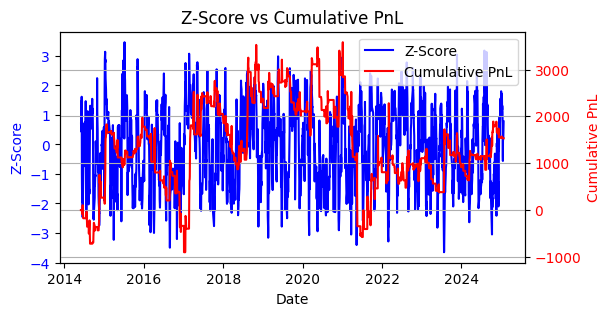

In [2]:
lockback_period = 20
entry_threshold = 2
exit_threshold = 1

# Instantiate strategy
strategy = SpreadTradingStrategy()
rb_hc_processed_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, window=lockback_period)

# Generate signals
rb_hc_processed_signal_df = strategy.evaluate_binomial_signals(rb_hc_processed_spread_df, window=lockback_period, entry_threshold=1.5, exit_threshold=0.5)
# Calculate PnL
pnl_df = strategy.calculate_binomial_pnl(rb_hc_processed_signal_df, 1)

fig, ax1 = plt.subplots(figsize=(6, 3))
# Plot z-score on primary y-axis
ax1.plot(pnl_df.index, pnl_df[f'z_score_{lockback_period}d'], color='blue', label='Z-Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Z-Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# Create secondary y-axis for Cumulative PnL
ax2 = ax1.twinx()
ax2.plot(pnl_df.index, pnl_df['CUM_PNL'], color='red', label='Cumulative PnL')
ax2.set_ylabel('Cumulative PnL', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Z-Score vs Cumulative PnL')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(True)

Normalized signal that sizes the potions

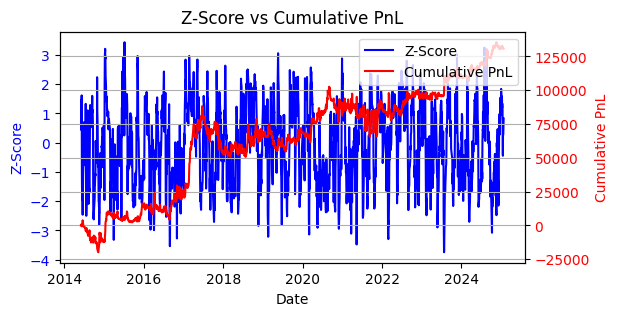

In [7]:
lockback_period = 21
entry_threshold = 2
exit_threshold = 1

# Process the spread data
rb_hc_20d_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, window=lockback_period)
# Generate z-score signals
rb_hc_continuous_signal_df = strategy.evaluate_z_score_signals(rb_hc_20d_spread_df, window=lockback_period, signal_col="Z_SCORE_SIGNAL")

# Calculate PnL
z_score_pnl_df = strategy.calculate_z_score_pnl(rb_hc_continuous_signal_df,signal_col="Z_SCORE_SIGNAL", window=lockback_period, hedge_ratio=1, entry_threshold=1, max_position_size=100)

fig, ax1 = plt.subplots(figsize=(6, 3))
# Plot z-score on primary y-axis
ax1.plot(z_score_pnl_df.index, z_score_pnl_df[f'z_score_{lockback_period}d'], color='blue', label='Z-Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Z-Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# Create secondary y-axis for Cumulative PnL
ax2 = ax1.twinx()
ax2.plot(z_score_pnl_df.index, z_score_pnl_df['CUM_PNL'], color='red', label='Cumulative PnL')
ax2.set_ylabel('Cumulative PnL', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Z-Score vs Cumulative PnL')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(True)

Mutiple signals with different windows to capture temporal infomation

d:\gitrepo\FICC_QIS\future_arb\lightgbm_strategy.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df[signal_col] = self.model.predict(X)


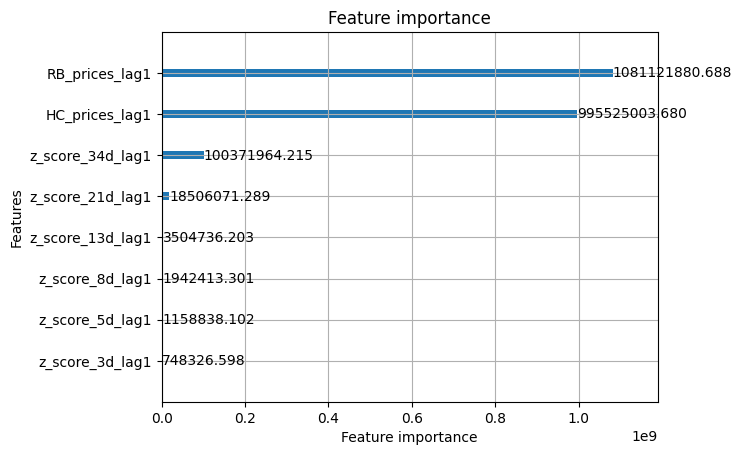

In [8]:
from future_arb.lightgbm_strategy import LightGBMSpreadTradingStrategy


lockback_periods = [1, 2, 3, 5, 8, 13, 21, 34]
hedge_ratio = 1
# entry_threshold = 2
# exit_threshold = 1

# Process the spread data
rb_hc_fibonacci_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, window=lockback_periods)

# Drop columns containing 'mean_' and 'sd_' from rb_hc_fibonacci_spread_df
display_cols = [col for col in rb_hc_fibonacci_spread_df.columns if not ("mean_" in col or "sd_" in col)]
rb_hc_fibonacci_spread_df[display_cols]

Y_cols = ["RB_HC_spread"]
X_cols = [col for col in display_cols if col not in Y_cols]
lagged_X_cols = []
for col in X_cols:
    rb_hc_fibonacci_spread_df[f"{col}_lag1"] = rb_hc_fibonacci_spread_df[col].shift(1)
    lagged_X_cols.append(f"{col}_lag1")
lagged_X_cols
"""
['HC_prices',
'RB_prices',
'z_score_1d',
'z_score_2d',
'z_score_3d',
'z_score_5d',
'z_score_8d',
'z_score_13d',
'z_score_21d',
'z_score_34d',
'z_score_55d',
'z_score_89d']
"""

# Prepare train test dataset
lightgbm_strat = LightGBMSpreadTradingStrategy(hedge_ratio)
xY_df = rb_hc_fibonacci_spread_df[lagged_X_cols + Y_cols]
train_df, test_df = lightgbm_strat.split_data(xY_df)

# Training model is at lightgbm_strat.model
lightgbm_strat.train_model(spread_df=train_df, feature_cols=lagged_X_cols, target_col=Y_cols)

# Feature importance
lgb.plot_importance(lightgbm_strat.model, importance_type="gain")

# Testing


# Evaulation
result_col = "LIGHTGBM_SIGNAL"
result_df = lightgbm_strat.predict_signals(xY_df, feature_cols=lagged_X_cols, signal_col=result_col)

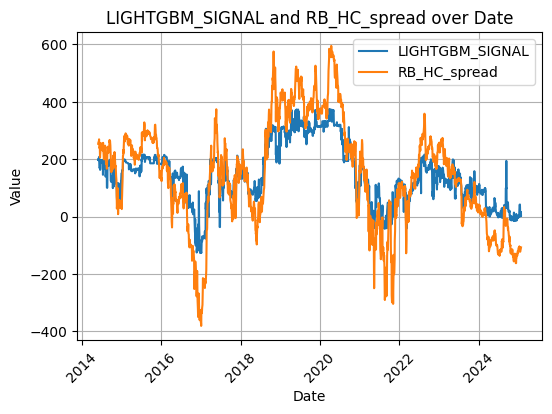

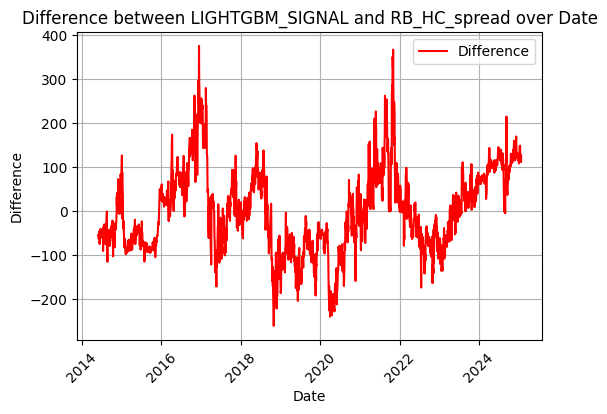

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(result_df.index, result_df['LIGHTGBM_SIGNAL'], label='LIGHTGBM_SIGNAL')
plt.plot(result_df.index, result_df['RB_HC_spread'], label='RB_HC_spread')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('LIGHTGBM_SIGNAL and RB_HC_spread over Date')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 计算两列的差值
diff = result_df['LIGHTGBM_SIGNAL'] - result_df['RB_HC_spread']

plt.figure(figsize=(6, 4))
plt.plot(result_df.index, diff, label='Difference', color='red')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('Difference between LIGHTGBM_SIGNAL and RB_HC_spread over Date')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Next day signal > Today spread:

d:\gitrepo\FICC_QIS\future_arb\lightgbm_strategy.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df[signal_col] = self.model.predict(X)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

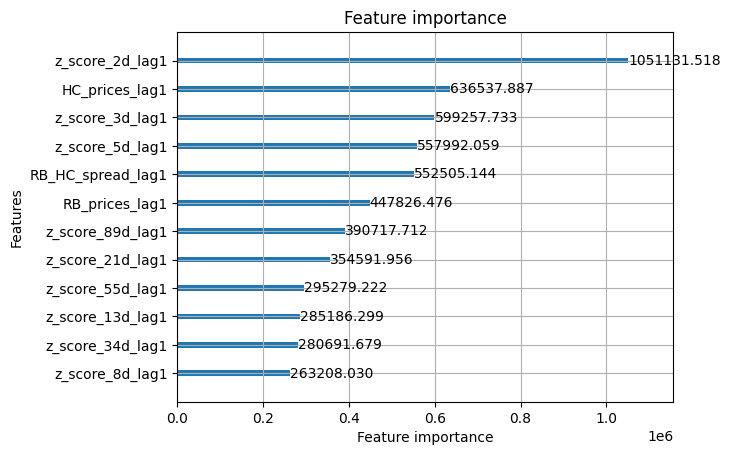

In [10]:
from future_arb.lightgbm_strategy import LightGBMSpreadTradingStrategy


lockback_periods = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
hedge_ratio = 1
# entry_threshold = 2
# exit_threshold = 1

# Process the spread data
rb_hc_fibonacci_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, window=lockback_periods)

# Drop columns containing 'mean_' and 'sd_' from rb_hc_fibonacci_spread_df
display_cols = [col for col in rb_hc_fibonacci_spread_df.columns if not ("mean_" in col or "sd_" in col)]
rb_hc_fibonacci_spread_df[display_cols]

rb_hc_fibonacci_spread_df["SPREAD_CHANGE"] = rb_hc_fibonacci_spread_df["RB_HC_spread"].diff()  # Calculate spread change
Y_cols = ["SPREAD_CHANGE"]
X_cols = [col for col in display_cols if col not in Y_cols]
lagged_X_cols = []
for col in X_cols:
    rb_hc_fibonacci_spread_df[f"{col}_lag1"] = rb_hc_fibonacci_spread_df[col].shift(1)
    lagged_X_cols.append(f"{col}_lag1")
lagged_X_cols
"""
['HC_prices',
'RB_prices',
'z_score_1d',
'z_score_2d',
'z_score_3d',
'z_score_5d',
'z_score_8d',
'z_score_13d',
'z_score_21d',
'z_score_34d',
'z_score_55d',
'z_score_89d']
"""

# Prepare train test dataset
lightgbm_strat = LightGBMSpreadTradingStrategy(hedge_ratio)
xY_df = rb_hc_fibonacci_spread_df[lagged_X_cols + Y_cols]
train_df, test_df = lightgbm_strat.split_data(xY_df)

# Training model is at lightgbm_strat.model
lightgbm_strat.train_model(spread_df=train_df, feature_cols=lagged_X_cols, target_col=Y_cols)

# Feature importance
lgb.plot_importance(lightgbm_strat.model, importance_type="gain")

# Testing


# Evaulation
result_col = "LIGHTGBM_SPREAD_CHANGE_SIGNAL"
result_df = lightgbm_strat.predict_signals(xY_df, feature_cols=lagged_X_cols, signal_col=result_col)

# Convert to positions
cum_pnl = lightgbm_strat.calculate_spread_change_signal_pnl(result_df, hedge_ratio=1, max_position_size=100)